<a href="https://colab.research.google.com/github/gelgel5633/self-study/blob/main/%ED%95%84%EC%82%AC/%EC%BA%90%EA%B8%80_%ED%83%80%EC%9D%B4%ED%83%80%EB%8B%89%ED%95%84%EC%82%AC_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 예측을 위한 EDA (다이타닉)
때떄로 삶은 유머의 잔인한 센스를 가지고 있는데, 가능한 최악의 시간에 당신이 원했던 것을 제공합니다 - Lisa Kleypas

타이타닉의 침몰은 역사상 가장 악명 높은 난파선 중 하나입니다.
1912년 4월 15일 첫 항해 때, 빙하에 충돌하여 가라앉았는데, 2224명 중 1502명의 승객과 선원을 죽였습니다. 그래서 다이타닉이라는 이름을 지은 이유입니다. 이것은 이 세상 그 누구도 잊을 수 없는 재앙입니다.

타이탁을 만드는 데 750만 달러가 들었고, 충돌로 인해 바다에 가라앉았습니다. 타이타닉 데이터셋은 데이터 사이언스와 캐글 대회에 참여하고자 하는 초보자들에게 매우 좋은 데이터 세트입니다.

이 노트북의 목표는 예측 모델링의 흐름이 어떻게 되는지 아이디어를 제공하는 것입니다. 기능을 확인하는 방법, 새로운 기능 및 일부 학습 개념을 추가하는 방법들에 대해서요. 모든 단계에 대해 초보자도 이해할 수 있도록 노력했습니다.

만약 이 노트북이 좋고 도움이 되었다고 생각하면 upvote 해주세요. 저에게 동기가 됩니다

## 이 노트북의 컨텐츠
part1 : EDA
- 피쳐 분석
- 여러 특성을 고려하여 관계나 트렌드를 찾습니다.

part2 : 피쳐 엔지니어링, 데이터 클리닝
- 새 특성을 추가합니다
- 불필요한 특성들을 삭제합니다.
- 모델링 한 것에 맞게 특성을 변환합니다.

part3 : 예측가능한 모델링
- 기본 알고리즘을 동작시킵니다
- 교차검증합니다
- 앙상블을 합니다
- 중요 특성을 추출합니다

# part1 : EDA

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [74]:
data = pd.read_csv("/content/drive/MyDrive/test/train.csv")

In [75]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [76]:
data.isnull().sum() #전체 null 값 체크

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

age, cabin(호실, 선실), embarked(항구)에 null 값이 있습니다. 나는 그들을 고치려고 할 것입니다

### 몇 명이나 살아남았는지?

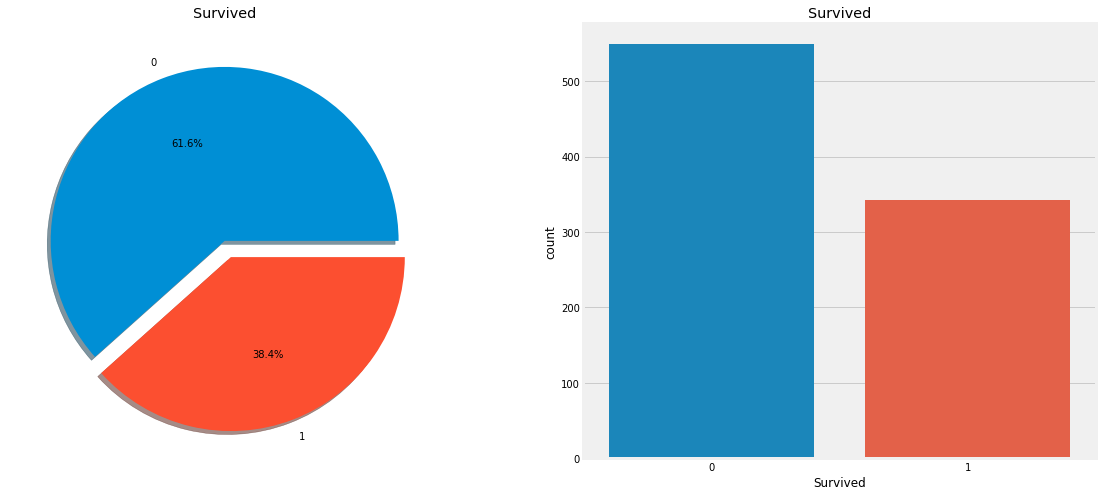

In [77]:
f, ax = plt.subplots(1,2,figsize=(18,8))
# 판다스 plot.pie 메서드, explode는 원형 기준으로 중앙에서 얼마나 벗어나는지?
data["Survived"].value_counts().plot.pie(explode=[0,0.1], autopct ="%1.1f%%", ax=ax[0], shadow=True)
ax[0].set_title("Survived")
ax[0].set_ylabel('')
sns.countplot("Survived", data=data, ax=ax[1])
ax[1].set_title("Survived")
plt.show()

사고에서 많은 승객들이 살아남지 못하였다는 것은 명확합니다.

훈련 세트에 있는 891명의 승객 중 약 350명만 생존했습니다. 즉, 전체 훈련 세트의 38.4%만이 충돌에서 생존했습니다. 데이터에서 더 나은 통찰력을 얻고 생존한 승객 범주와 생존하지 못한 승객 범주를 확인하려면 더 자세히 조사해야 합니다.

우리는 데이터셋의 다른 특징들을 사용해서 생존률을 체크하기 위해 노력해야합니다. 이 특징들의 일부는 성별, 선박, 나이 등이 있습니다.

우선 다양한 특성에 대한 이해를 먼저 두겠습니다

### 특성의 타입

범주형 특성:
범주형 변수는 둘 혹은 그 이상의 카테고리가 그들 스스로에 의해 분류될 수 있습니다. 예를 들어 성별은 두 카테고리 변수로 카테고리(범주)화 됩니다. 이제 우리는 이러한 변수를 정렬할 수 없습니다. 이를 명목변수(Nominal Variables)라고 합니다.

이 데이터 셋에서 범주형 변수 : 성별, 항구


순차 특성(ordinal):
순차 특성은 범주형 변수와 유사하지만, 차이점은 값 간에 정렬하는 것이 가능하거나 상대적인 순서를 가진다는 점입니다. 예를 들어 몸무게는 크다, 중간, 작다의 값을 가질 수 있는데, 몸무게를 순차형 변수라고 합니다. 변수에서 연관된 정렬을 할 수 있습니다.

이 데이터 셋에서 PClass 가 여기에 해당됩니다.


연속형 특성:
특성 열의 두 점 사이 또는 최대값 또는 최솟값 사이의 값을 취할 수 있는 경우 연속적이라고 합니다.

이 데이터 셋에서 Age가 여기에 해당됩니다.


## 특성분석

## 성별 -> 범주형 특성으로

In [78]:
data.groupby(["Sex", "Survived"])["Survived"].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

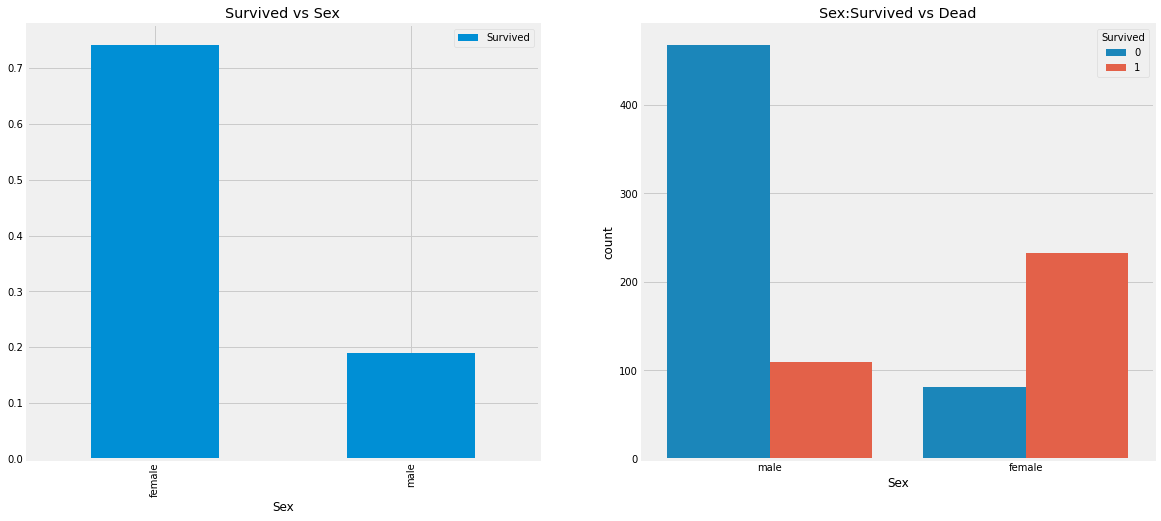

In [79]:
f, ax = plt.subplots(1,2,figsize=(18,8))
data[["Sex", "Survived"]].groupby(["Sex"]).mean().plot.bar(ax=ax[0])
ax[0].set_title("Survived vs Sex")
sns.countplot("Sex", hue = "Survived", data = data, ax=ax[1])
ax[1].set_title("Sex:Survived vs Dead")
plt.show()

흥미롭습니다. 배에 탄 남자들의 수가 여자의 수보다 많습니다. 여전히 구조된 여성의 수는 구조된 남성의 수의 거의 두 배 입니다. 배에 탄 여성의 생존률은 약 75%이고 남성의 생존률은 약 18~19%입니다.

모델링을 함에 있어서 매우 중요한 특성으로 보입니다. 그러나 이것이 최선일까요? 다른 특성도 체크해봅시다

## Pclass -> 순차형 특성

In [80]:
pd.crosstab(data.Pclass, data.Survived, margins=True).style.background_gradient(cmap="summer_r")

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


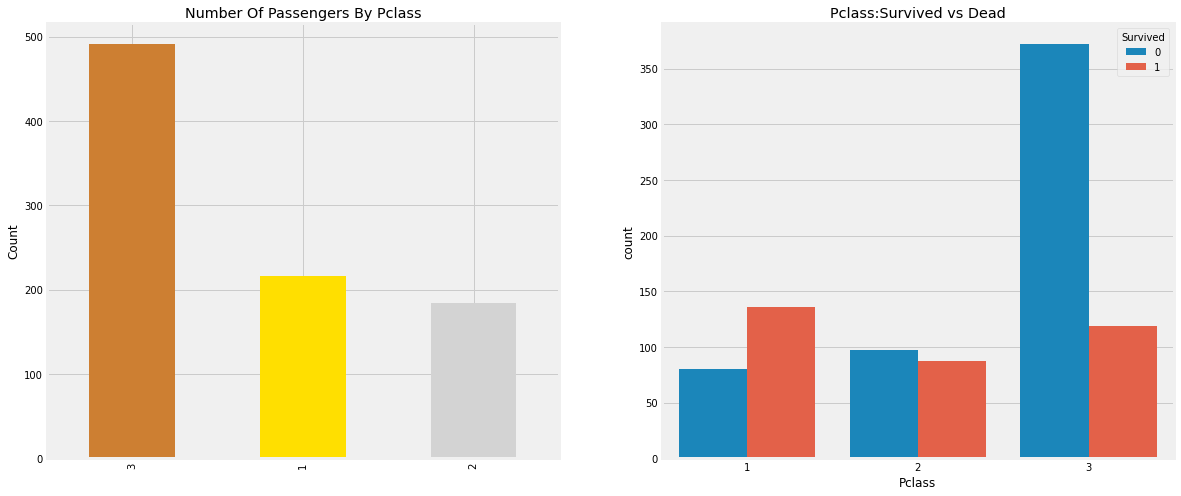

In [81]:
f, ax = plt.subplots(1,2,figsize=(18,8))
data["Pclass"].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'],ax=ax[0])
ax[0].set_title("Number Of Passengers By Pclass")
ax[0].set_ylabel("Count")
sns.countplot("Pclass", hue="Survived", data=data, ax=ax[1])
ax[1].set_title("Pclass:Survived vs Dead")
plt.show()

사람들은 돈으로 무엇이라도 살 수 없다고 말합니다. 하지만 우리는 Pclass 1이 구조를 받는 동안 매우 높은 우선순위를 받았다는 것을 명확히 볼 수 있습니다. 비록 Pclass3이 승객 수가 훨씬 많았음에도 25% 근처일정도로 생존률이 매우 낮습니다.

Pclass 1의 생존률은 63%이고, Pclass 2의 경우 약 48% 입니다. 그래서 이런 자본주의 사회에서는 돈과 지위가 중요합니다. 

조금 더 자세히 살펴보고 다른 흥미로운 관찰을 해보겠습니다. 성별과 Pclass를 함께 이용하여 생존률을 확인해보겠습니다.

In [82]:
pd.crosstab([data.Sex,data.Survived], data.Pclass, margins=True).style.background_gradient(cmap="summer_r")

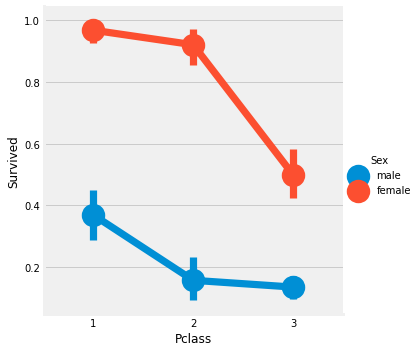

In [83]:
sns.factorplot("Pclass", "Survived", hue="Sex", data=data)
plt.show()

우리는 이 경우 factorpot을 사용합니다. 왜냐하면 범주형 변수의 분리를 쉽게할 수 있기 때문입니다.
crosstab과 factorplot을 볼 떄 우리는 pclass의 여성이 95~96%로 살아남는것을 추론할 수 있습니다. (pclass1의 94명의 여성중 오직 3명이 사망했습니다)

이로서 pclass와 상관관계가 있는 것이 명확해졌습니다. 여성은 구조를 받을 때 우선권을 받았습니다. 비록 pclass1의 남성이 매우 낮은 생존률을 가졌지만요.

pclass도 역시 매우 중요한 특성으로 보입니다. 다른 특성도 분석해봅시다.

### 나이 -> 연속형 변수

In [84]:
print("oldest passenger :", data["Age"].max(), "Years")
print("youngest passenger :", data["Age"].min(), "Years")
print("Average Age on the ship :", data["Age"].mean(), "Years" )

oldest passenger : 80.0 Years
youngest passenger : 0.42 Years
Average Age on the ship : 29.69911764705882 Years


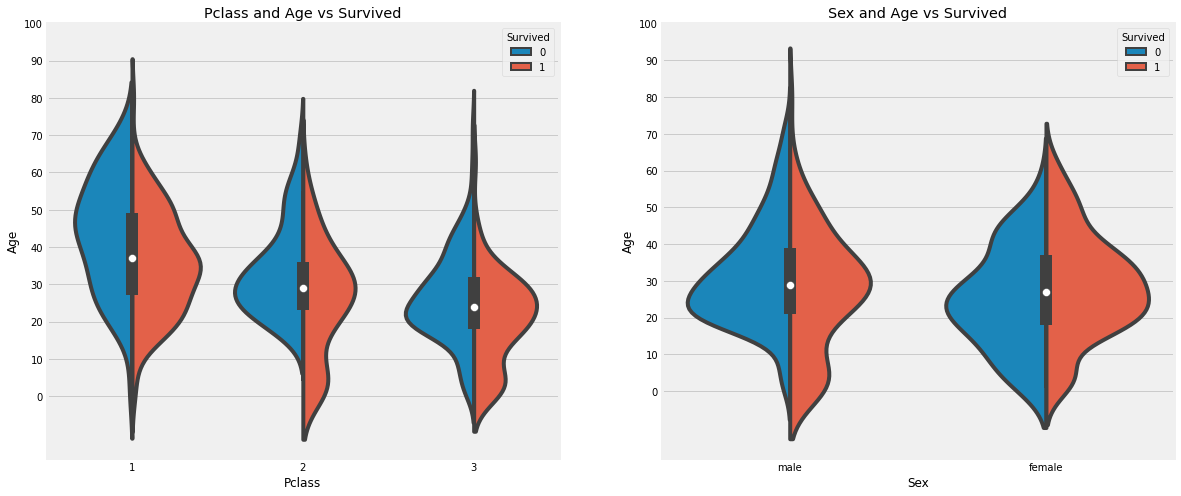

In [85]:
f,ax = plt.subplots(1,2,figsize=(18,8))
sns.violinplot("Pclass", "Age", hue = "Survived", data=data, split=True, ax=ax[0])
ax[0].set_title("Pclass and Age vs Survived")
ax[0].set_yticks(range(0,110,10))
sns.violinplot("Sex", "Age", hue = "Survived", data=data, split=True, ax=ax[1])
ax[1].set_title("Sex and Age vs Survived")
ax[1].set_yticks(range(0,110,10))
plt.show()

관찰:
- 아이들의 수는 pclass에 상관없이 증가하고 10세 미만의 승객의 생존율은 pclass에 상관없이 양호합니다
- pclass1의 20~50세 승객의 생존가능성이 높고 여성이 더 생존확률이 높습니다.
- 남성의 경우 나이가 들수록 생존 확률이 낮아집니다.

우리가 이전에 봤듯 age 특성은 177개가  null값으로 되어있습니다. 이 nan값들을 대체하기 위해 우리는 데이터셋의 평균 나이로 할당할 수 있습니다.
그러나 문제는, 다양한 사람이 있는 만큼 다양한 연령대도 존재합니다. 우리는 평균 연령이 29세인 4살 아이를 설정할 수 없습니다. 승객이 거짓말하는 연령대를 알 수 있는 방법이 있을까요?

있습니다. 우리는 이름 특성을 체크할 수 있습니다. 특성을 살펴보면 우리는 mr 또는 mrs와 같은 인사말이 있음을 알 수 있습니다. 따라서 mr 및 mrs의 평균 값을 각 그룹에 할당할 수 있습니다.

이름에 무엇이 있는지? => 특성이 있습니다.

In [86]:
data["Initial"] = 0
for i in data:
    data["Initial"] = data.Name.str.extract('([A-Za-z]+)\.') #인사말?을 추출해봅시다
    
#str.extract는 판다스 기능. 정규표현식을 사용하여 원하는 형태를 추출하는 것이 가능

우리는 정규표현식을 사용합니다. [A-Za-z]+).. A-Za-z사이에 있고 뒤에 .(점)이 오는 문자열을 찾는 것입니다. 따라서 이름에서 이니셜을 성공적으로 추출할 수 있습니다.


In [87]:
pd.crosstab(data.Initial, data.Sex).T.style.background_gradient(cmap="summer_r") 
# 인삿말과 성별을 체크

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


MIIE Mme와 같이 Miss를 나타내는 철자가 틀린 이니셜이 있습니다. 이것들을 Miss로 대체하고 다른 값에 대해서도 바꿀 것입니다.

In [88]:
data['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer',
    'Col','Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs',
    'Other','Other','Other','Mr','Mr','Mr'],inplace=True)

In [89]:
data.groupby("Initial")["Age"].mean()
# 이니셜에 따른 평균 연령을 체크합니다

Initial
Master     4.574167
Miss      21.860000
Mr        32.739609
Mrs       35.981818
Other     45.888889
Name: Age, dtype: float64

### nan age값 채우기

In [90]:
# 평균 나이로 nan 값 할당하기
data.loc[(data.Age.isnull()) & (data.Initial=="Mr"), "Age"] =33
data.loc[(data.Age.isnull()) & (data.Initial=="Mrs"), "Age"] = 36
data.loc[(data.Age.isnull()) & (data.Initial=="Master"), "Age"] = 5
data.loc[(data.Age.isnull()) & (data.Initial=="Miss"), "Age"] = 22
data.loc[(data.Age.isnull()) & (data.Initial=="Other"), "Age"] = 46

In [91]:
data.Age.isnull().any() #최종적으로 남은 null value는 없다

False

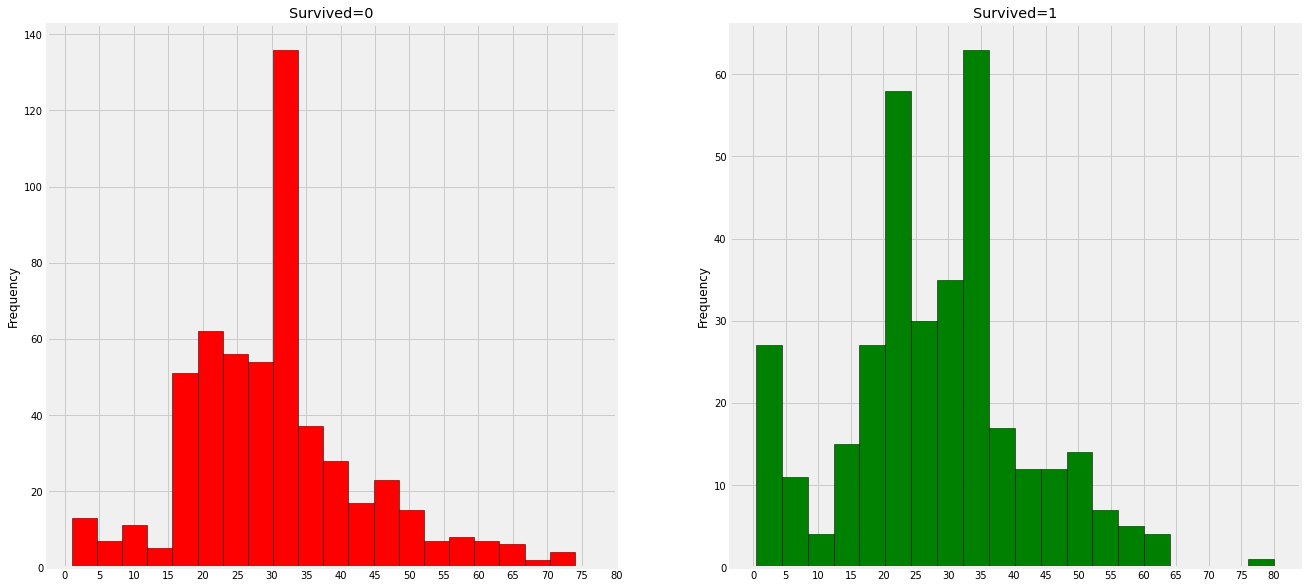

In [92]:
f,ax = plt.subplots(1,2,figsize=(20,10))
data[data["Survived"]==0].Age.plot.hist(ax=ax[0], bins=20, edgecolor="black", color="red")
ax[0].set_title("Survived=0")
x1=list(range(0,85,5))
ax[0].set_xticks(x1)
data[data["Survived"]==1].Age.plot.hist(ax=ax[1], color="green", bins=20, edgecolor="black")
ax[1].set_title("Survived=1")
x2=list(range(0,85,5))
ax[1].set_xticks(x2)
plt.show()

관찰 : 
- toddlers(5세 미만)가 많이 살아남았습니다(여성, 아동 우선 정책)
- 살아남은 가장 나이많은 승객의 나이는 80세
- 사망자 수의 가장 많은 연령대는 30~40세


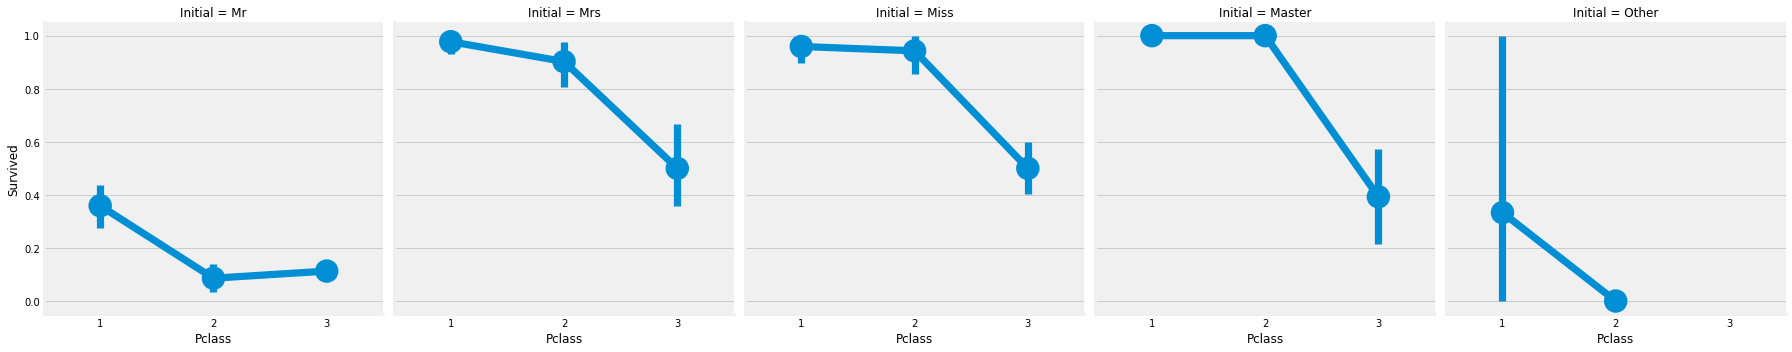

In [93]:
sns.factorplot("Pclass", "Survived", col="Initial", data=data)
plt.show()

여성 아동 우대정책은 class에 무관합니다
embarked -> 범주형 변수

In [94]:
pd.crosstab([data.Embarked,data.Pclass], [data.Sex, data.Survived], margins=True).style.background_gradient(cmap="summer_r")

승선항의 생존 가능성

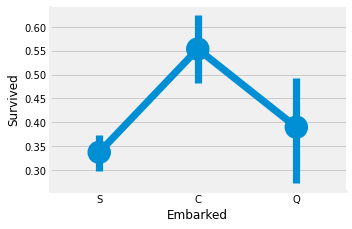

In [95]:
sns.factorplot("Embarked", "Survived", data=data)
fig = plt.gcf()
fig.set_size_inches(5,3)
plt.show()

항구 c의 생존 가능성이 가장 높은 곳은 0.55부근이고, s의 경우 가장 낮습니다

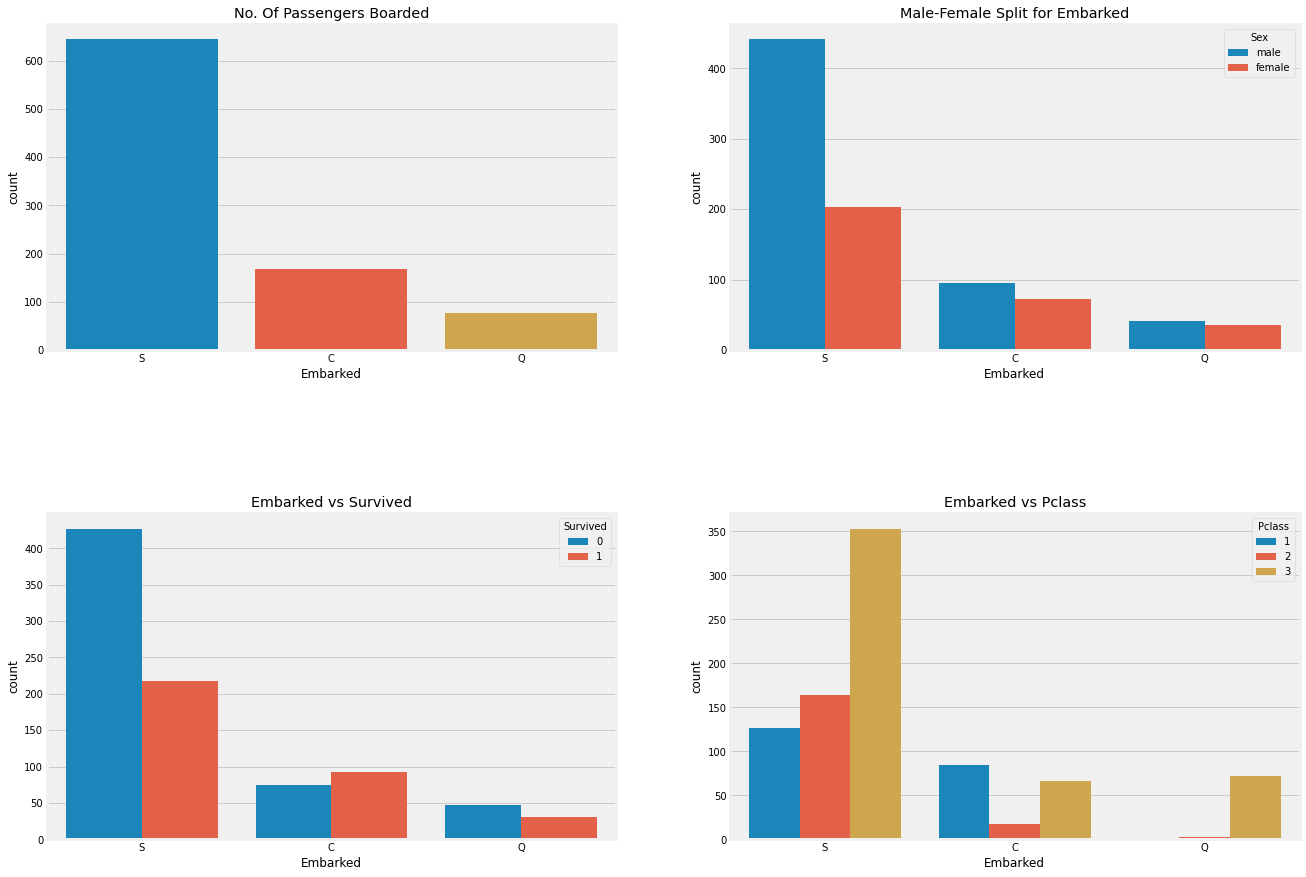

In [96]:
f,ax= plt.subplots(2,2,figsize=(20,15))
sns.countplot("Embarked",data=data,ax=ax[0,0])
ax[0,0].set_title("No. Of Passengers Boarded")
sns.countplot("Embarked", hue="Sex", data=data, ax=ax[0,1])
ax[0,1].set_title("Male-Female Split for Embarked")
sns.countplot("Embarked", hue = "Survived", data=data, ax=ax[1,0])
ax[1,0].set_title("Embarked vs Survived")
sns.countplot("Embarked", hue="Pclass", data=data, ax=ax[1,1])
ax[1,1].set_title("Embarked vs Pclass")
plt.subplots_adjust(wspace=0.2,hspace=0.5)
plt.show()

관찰:
- S에서 탑승한 승객이 대부분 pclass 3입니다
- C에서 온 승객은 대부분 살아남았는데, pclass1 및 2의 승객일 것입니다
- S는 대다수 부자들이 탑승한 항구를 보고 있습니다. 여전히 생존가능성은 낮습니다. pclass 3의 승객중 81%정도가 생존하지 못했습니다.
- Q는 승객의 95%가 pclass 3입니다.

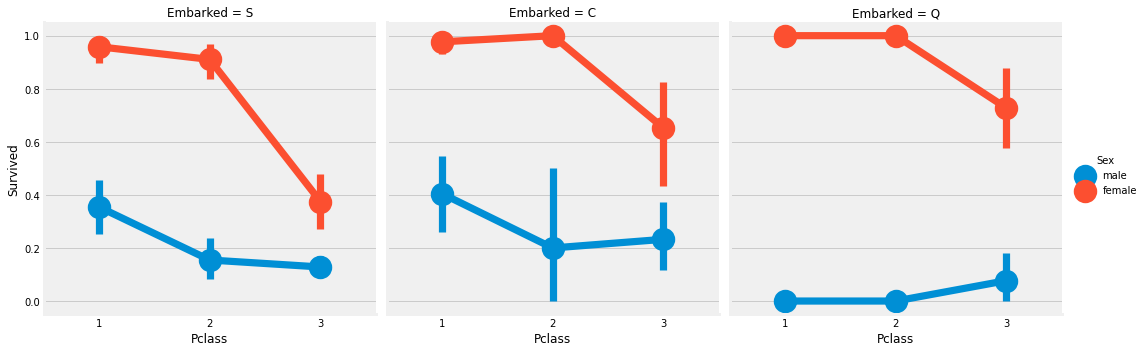

In [97]:
sns.factorplot("Pclass", "Survived", hue="Sex", col="Embarked", data=data)
plt.show()

관찰
- pclass에 관계없이 pclass1과 2에서 여성의 생존확률은 거의 1입니다.
- 남녀 모두 생존률이 낮기 때문에 S에서는 pclass3 승객이 매우 불행한 것으로 보입니다.
- Q는 거의 모든 pclass에서 나왔기 때문에 남성에게 가장 불행한 것 같습니다.

### embarked nan값 채우기
우리가 봤듯 대부분의 승객은 s에서 탑승했으므로 nan값을 s로 대체하겠습니다

In [98]:
data["Embarked"].fillna("S", inplace=True)

In [99]:
data.Embarked.isnull().any() #nan 값이 존재하지 않게됨

False

SibSip -> Discrete Feature(이산 특성)
이 특성은 사람이 혼자인지 가족과 함께 있는지를 나타냅니다.
- sibling = brother, sister, stepbrother, stepsister
- #형제자매 = 형제, 자매, 이복형제, 이복자매
- Spouse = husband, wife
- #배우자 = 남편, 아내

In [100]:
pd.crosstab([data.SibSp], data.Survived).style.background_gradient(cmap="summer_r")

Survived,0,1
SibSp,,
0,398,210
1,97,112
2,15,13
3,12,4
4,15,3
5,5,0
8,7,0


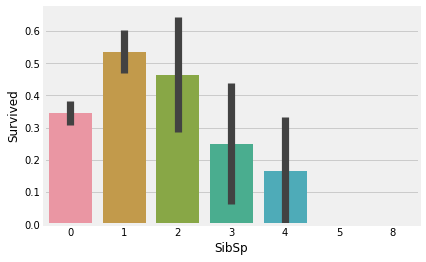

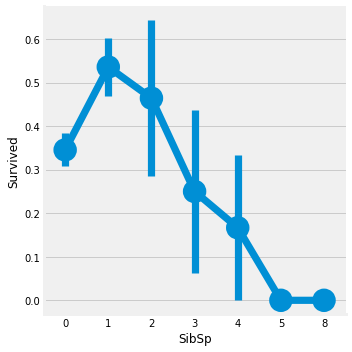

In [101]:
sns.barplot("SibSp", "Survived", data=data)
sns.factorplot("SibSp", "Survived", data=data)
plt.show()

In [102]:
pd.crosstab(data.SibSp,data.Pclass).style.background_gradient(cmap="summer_r")

Pclass,1,2,3
SibSp,,,
0,137,120,351
1,71,55,83
2,5,8,15
3,3,1,12
4,0,0,18
5,0,0,5
8,0,0,7


관찰:
barplot과 factorplot은 형제자매없이 혼자 탑승할 경우 생존률이 34.5%임을 보여줍니다. 형제자매 수가 증가하면 그래프가 감소합니다.
배에 가족이 있다면 나 자신보다 가족을 구하려고 합니다. 놀랍게도 5-8인 가족의 생존률은 0%입니다.

이유는 pclass입니다. 교차분석은 SibSp>3 인 사람이 모두 pclass3에 있음을 보여줍니다.pclass3의 모든 대가족이 사망이 임박했습니다

### parch(동승한 부모/자식의 수)

In [103]:
pd.crosstab(data.Parch, data.Pclass).style.background_gradient(cmap="summer_r")

Pclass,1,2,3
Parch,,,
0,163,134,381
1,31,32,55
2,21,16,43
3,0,2,3
4,1,0,3
5,0,0,5
6,0,0,1


crosstab은 가족의 수가 클 수록 pclass3에 있는 것을 보여줍니다

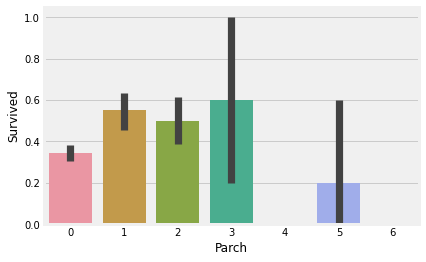

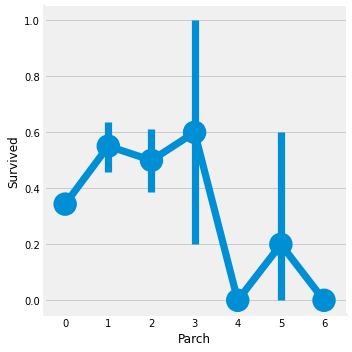

In [104]:
sns.barplot("Parch", "Survived", data=data)
sns.factorplot("Parch", "Survived", data=data)
plt.show()

관찰 : 
여기에서도 결과는 매우 유사합니다. 부모와 함께 탑승한 승객은 생존 가능성이 더 높습니다. 그러나 숫자가 올라갈수록 감소합니다.

배에 1~3명의 부모가 있는 사람에게는 생존 가능성이 좋습니다. 혼자 있는 것도 치명적이며 누군가가 배에 4명 이상의 부모가 있는 경우 생존 가능성이 감소합니다.

### 요금 -> 연속적 특성

In [105]:
print("highest fare:", data["Fare"].max())
print("Lowest fare:", data["Fare"].min())
print("Average fare:", data["Fare"].mean())

highest fare: 512.3292
Lowest fare: 0.0
Average fare: 32.204207968574636


가장 낮은 운임비는 0입니다. 호화롭군요

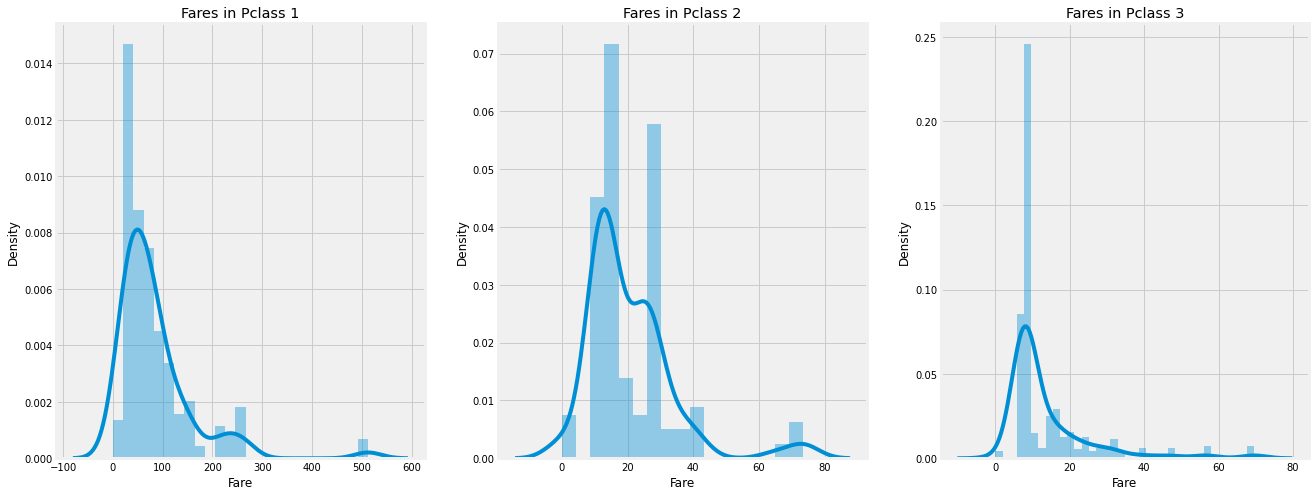

In [106]:
f,ax = plt.subplots(1,3,figsize=(20,8))
sns.distplot(data[data["Pclass"] == 1].Fare, ax=ax[0])
ax[0].set_title("Fares in Pclass 1")
sns.distplot(data[data["Pclass"] == 2].Fare, ax=ax[1])
ax[1].set_title("Fares in Pclass 2")
sns.distplot(data[data["Pclass"] == 3].Fare, ax=ax[2])
ax[2].set_title("Fares in Pclass 3")
plt.show()

pclass1 승객의 운임 분포가 크게 나타나고, 이 분포는 기준이 감소함에 따라 계속 감소합니다. 이것도 연속적으로 binning(구간나누기)를 사용하여 이산 값으로 변환할 수 있습니다.

### 모든 특성에 대한 관찰
- 성별 : 여성의 생존 가능성은 남성에 비해 높습니다.
- pclass : 1등성 승객이 되면 생존 가능성이 더 높아진다는 가시적 추세가 있습니다. pclass3의 생존율은 매우 낮습니다. 여성의 경우 pclass1의 생존률은 거의 1이고 pclass2의 생존 확률도 높습니다. 돈은 승리합니다.
- 연령 : 5\~10세 미만의 어린이는 생존 가능성이 높습니다. 15~35세 사이의 승객이 많이 사망했습니다.
- Embarked : 이것은 매우 흥미로운 기능입니다. pclass1 승객의 대다수가 s에서 승선했음에도 불구하고 c에서 생존할 가능성이 더 높아 보입니다. q의 승객은 모두 pclass 3이었습니다
- Parch+SibSp : 1\~2명의 형제 자매 배우자가 탑승하거나, 1~3명의 부모가 있는 경우 혼자이거나 대가족이 함께 여행하는 것보다 가능성이 더 높습니다.

## 특성간 상관관계

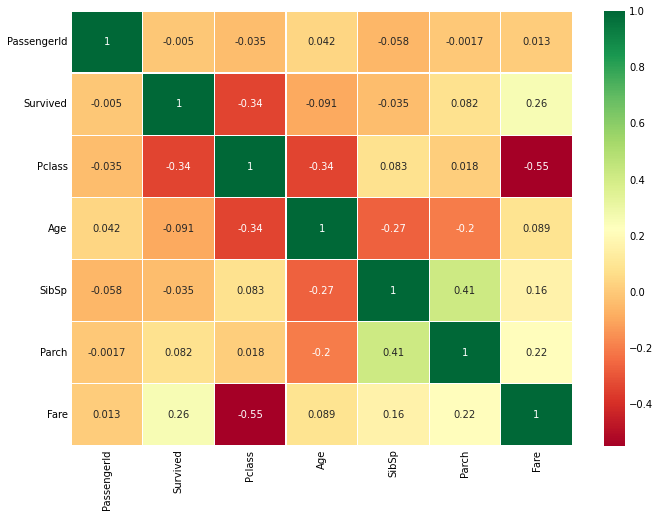

In [107]:
sns.heatmap(data.corr(), annot=True, cmap = "RdYlGn", linewidths=0.2) #상관 매트릭스
fig=plt.gcf()
#gcf() = get_currnet_figure // figure를 하나도 설정하지 않았을 경우 사용
fig.set_size_inches(10,8)
plt.show()

### 히트맵 해석
- 가장 먼저 주목해야 할 것은 알파벳이나 문자열 사이의 상관관계를 알 수 없다는 것이 분명하기 때문에 숫자 기능만 비교된다는 것입니다. 플롯을 이해하기전에 상관관계가 무엇인지 살펴보겠습니다.
- 양의 상관관계 : 특성 A의 증가가 특성 B의 증가로 이어진다면 양의 상관관계가 있습니다. 값1은 완전한 양의 상관관계를 의미합니다
- 음의 상관관계 : 특성 A의 증가가 특성 B의 감소로 이어지는 경우, 음의 상관관계가 있습니다. 값-1은 완전한 음의 상관관계를 의미합니다.
- 이제 두 기능이 고도로 또는 완벽하게 상관관계가 있으므로 하나의 증가가 다른 특성의 증가로 이어진다고 가정해보겠습니다. 이는 두 기능 모두 매우 유사한 정보를 포함하고 있으며 정보의 변동이 거의 없거나 전혀 없음을 의미합니다. 둘 다 거의 동일한 정보를 포함하므로 이를 다중공선성이라고 합니다.
- 둘 둥 하나가 중복되므로 둘 다 사용해야한다고 생각하십니까? 모델을 만들거나 훈련하는 동안 훈련 시간과 많은 이점을 줄이므로 중복 기능을 제거하려고 노력해야합니다.
- 이제 위의 히트맵에서 특징이 그다지 상관관계가 없음을 알 수 있습니다. 가장 높은 상관관계는 SibSp와 Parch사이, 즉, 0.41입니다. 따라서 모든 기능을 계속 사용할 수 있습니다.

### 2부 : 피쳐 엔지니어링 및 데이터 정리
- 피쳐 엔지니어링이란 무엇입니까?
- 피쳐가 있는 데이터 세트가 제공될 때마다 모든 기능이 중요할 필요는 없습니다. 제거해야 할 중복 기능이 많을 수 있습니다. 또한 다른 기능을 관찰하거나 정보를 추출하여 새로운 기능을 얻거나 추가할 수 있습니다.
- 예를 들어 이름 기능을 사용하여 이니셜 기능을 가져오는 것이 있습니다. 새로운 기능을 얻고 몇 가지를 제거할 수 있는지 봅시다. 또한 기존 관련 기능을 예측가능한 모델링에 적합한 형식으로 변환합니다.


### Age_band 연령 특성 문제:
- 나이는 연속적인 특성이라고 앞서 언급했듯이 기계학습 모델의 연속 변수에는 문제가 있습니다.
- 예 : 스포츠인을 성별로 그룹화하거나 정렬하라고 하면  쉽게 남성과 여성으로 구분할 수 있습니다.
- 이제 연령별로 그룹화하라고 하면 어떻게 하시겠습니까? 30명의 사람이 있는 경우 30개의 연령 값이 있을 수 있습니다. 이제 이것이 문제가 됩니다.
- 구간설정 또는 정규화를 통해 이러한 연속값을 범주형 값으로 변환해야합니다. 나는 구간 설정을 사용할 것입니다. 즉, 연령 범위를 단일 구간으로 그룹화하거나 단일 값을 할당할 것입니다.
- 좋습니다. 승객의 최대 연령은 80세였습니다. 따라서 0~80의 범위를 5개의 구간으로 나눕니다. 따라서 80/5=16입니다. 따라서 16의 구간을 가지게 됩니다

In [108]:
data['Age_band']=0
data.loc[data['Age']<=16,'Age_band']=0
data.loc[(data['Age']>16)&(data['Age']<=32),'Age_band']=1
data.loc[(data['Age']>32)&(data['Age']<=48),'Age_band']=2
data.loc[(data['Age']>48)&(data['Age']<=64),'Age_band']=3
data.loc[data['Age']>64,'Age_band']=4
data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Age_band
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2


In [109]:
data["Age_band"].value_counts().to_frame().style.background_gradient(cmap="summer")
#각 밴드별 승객의 수 체크

,Age_band
1,382
2,325
0,104
3,69
4,11


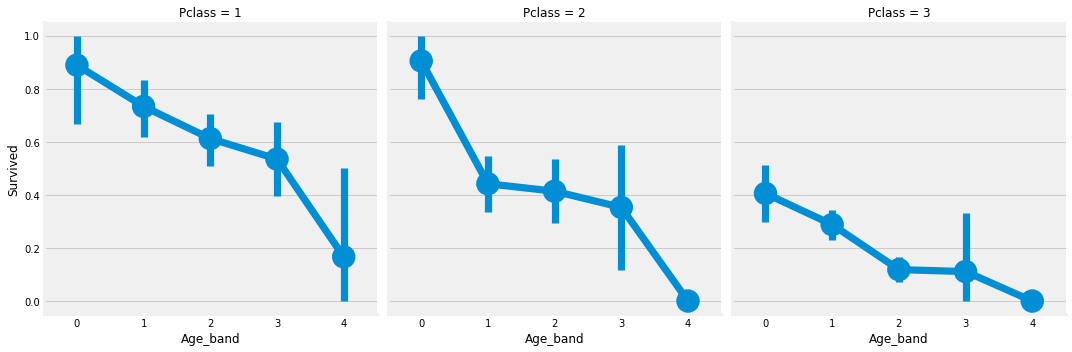

In [110]:
sns.factorplot("Age_band", "Survived", data=data, col = "Pclass")
plt.show()

사실 pclass와 상관없이 연령이 증가할수록 생존율이 감소합니다.

family_size // alone
- 이 시점에서 family_size, alone 이라는 새로운 기능을 생성하고 분석할 수 있습니다.
- 이 기능은 parch와 sibsp의 합입니다.
- 생존율이 승객의 가족 규모와 관련이 있는지 확인할 수 있도록 결합된 데이터를 제공합니다.
- alone은 승객이 혼자인지 여부를 나타냅니다

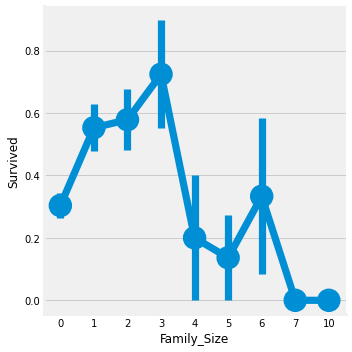

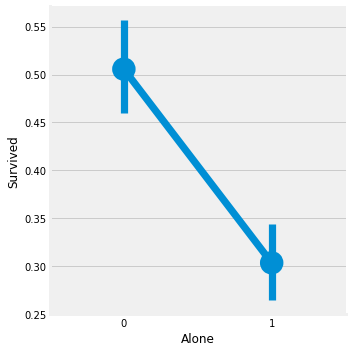

In [111]:
data["Family_Size"] = 0
data["Family_Size"] = data["Parch"]+data["SibSp"] #패밀리의 수
data["Alone"] = 0
data.loc[data.Family_Size==0, "Alone"] = 1

#f,ax = plt.subplots(1,2,figsize=(18,6))
sns.factorplot("Family_Size", "Survived", data=data)
sns.factorplot("Alone", "Survived", data=data)
plt.show()

#첫번째는 family_size vs survived
#두번째는 alone vs survived

family_size가 0이라는 의미는 승객 혼자라는 뜻입니다. 명확하게 혼자이거나 family_size가 0이라면 살아남을 확률은 매우 낮습니다. family_size가 4보다 큰 경우에도 확률이 감소합니다. 모델에서 중요한 변수가 될 수 있을 것으로 보입니다. 더 조사해봅시다

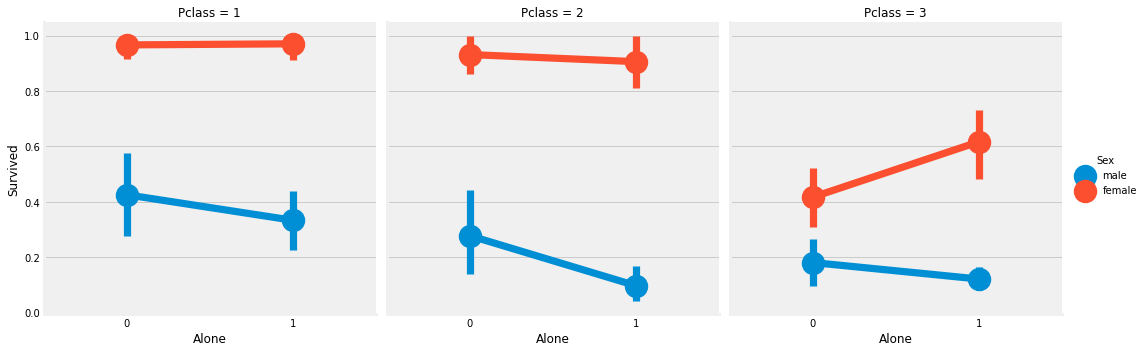

In [112]:
sns.factorplot("Alone","Survived", data=data, hue="Sex", col = "Pclass")
plt.show()

- 혼자있는 여성이 가족이 있는 여성보다 혼자일 확률이 높은 pclass3를 제외하고는 성별이나 pclass를 불문하고 혼자있는 것이 해롭다는 것을 알 수 있습니다.
- fare_range 요금도 연속적 특성이므로 서수값으로 변환해야 합니다
- 이를 위해 우리는 pandas.qcut을 사용할 것입니다.
- 따라서 qcut이 하는 일은 우리가 전달한 구간의 수에 따라 값을 분할하거나 정렬하는 것입니다. 따라서 5개의 구간에 대해 전달하면 5개의 별도 구간 또는 값 범위에 균등한 간격으로 값을 정렬합니다

In [113]:
data["Fare_Range"] = pd.qcut(data["Fare"], 4)
data.groupby(["Fare_Range"])["Survived"].mean().to_frame().style.background_gradient(cmap="summer_r")
#qcut은 같은 개수로 구간을 나눌 때 사용// 모든 구간에서 샘플의 수가 동일
#cut은 간격을 생성하되 간격별 샘플 갯수는 다름

,Survived
Fare_Range,
"(-0.001, 7.91]",0.197309
"(7.91, 14.454]",0.303571
"(14.454, 31.0]",0.454955
"(31.0, 512.329]",0.581081


위에서 토론한대로 fare_range 증가함으로써 생존률의 증가를 명확히 볼 수 있습니다.
이제 우리는 fare_range를 그것 그대로 보고 지나칠 수 없다. 우리는 age_band에서 했던 것과 같은 singleton(개체) 값으로 변경해야합니다

In [114]:
data["Fare_cat"]= 0
data.loc[data["Fare"]<=7.91, "Fare_cat"]=0
data.loc[(data["Fare"]>7.91) & (data["Fare"]<=14.454), "Fare_cat"]=1
data.loc[(data["Fare"]>14.454) & (data["Fare"]<=31), "Fare_cat"]=2
data.loc[(data["Fare"]>31) & (data["Fare"]<=513), "Fare_cat"]=3

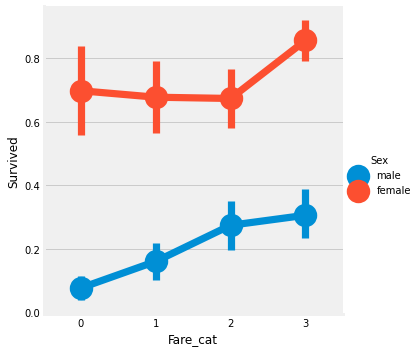

In [115]:
sns.factorplot("Fare_cat", "Survived", data=data, hue="Sex")
plt.show()

- 분명히 fare_cat이 증가할수록 생존확률이 높아집니다. 이 기능은 성별과 함께 모델링 시 중요한 기능이 될 수 있습니다. 문자열 값을 숫자로 변환하지 않으면 기계학습모델에 전달할 수 없기 때문에 숫자값으로 변환하여야 합니다

In [116]:
data["Sex"].replace(["male", "female"], [0,1], inplace=True)
data["Embarked"].replace(["S","C","Q"],[0,1,2], inplace = True)
data["Initial"].replace(["Mr", "Mrs", "Miss", "Master", "Other"], [0,1,2,3,4], inplace = True)

### 불필요한 기능 삭제
- 이름 : 범주형 값으로 변환할 수 없기 때문에 필요하지 않습니다.
- 나이 : age_band 기능이 있으므로 필요하지 않습니다
- 티켓 : 분류할 수 없는 임의의 문자열입니다.
- 요금 : fare_cat이 있으므로 필요없습니다.
- 선실 : nan값이 많고 많은 승객이 여러개의 객실을 가지고 있습니다. 따라서 쓸모가 없습니다.
- 요금 범위 : fee_cat 기능이 있습니다
- 승객 id : 분류할 수 없습니다.

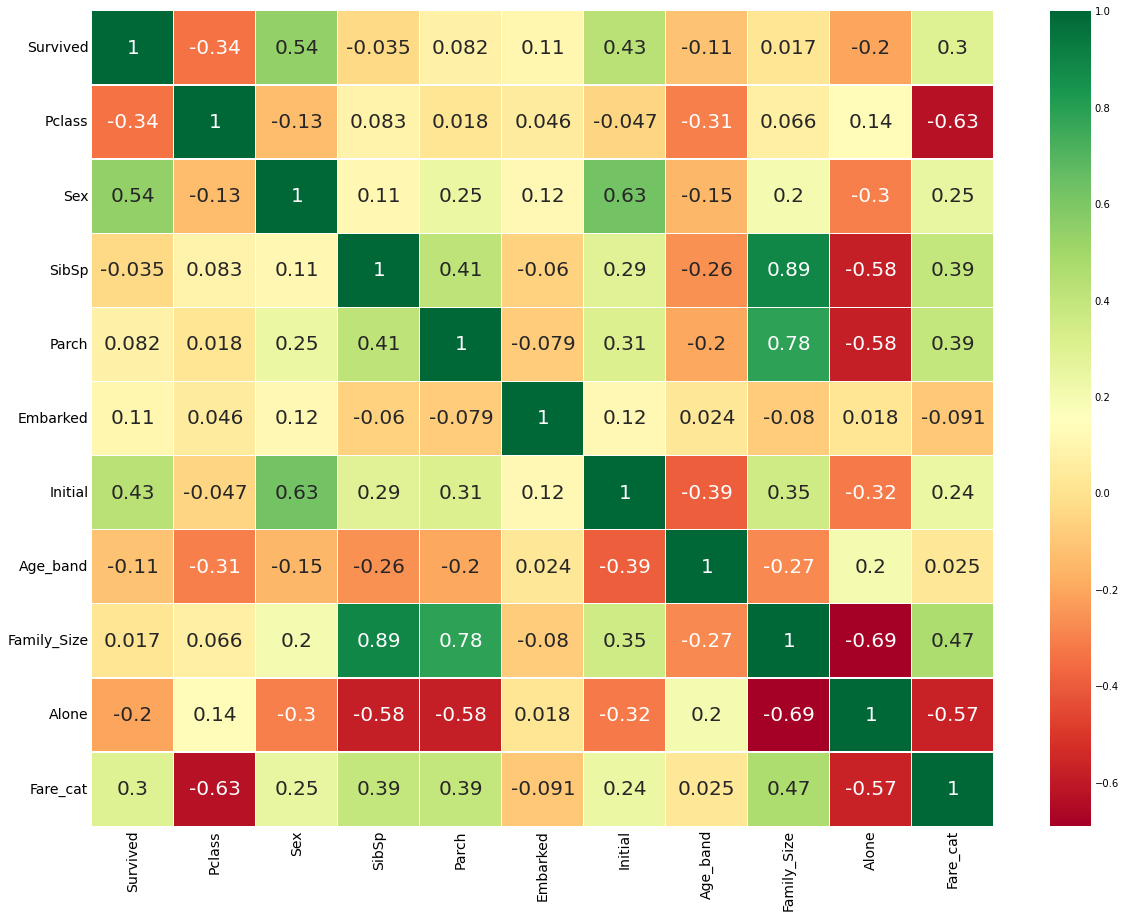

In [117]:
data.drop(["Name", "Age", "Ticket", "Fare", "Cabin", "Fare_Range", "PassengerId"], axis=1, inplace = True)
sns.heatmap(data.corr(), annot=True, cmap="RdYlGn", linewidths=0.2, annot_kws={"size":20})
fig=plt.gcf()
fig.set_size_inches(18,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

- 이제 위의 상관관계플롯에서 몇 가직 긍정적 관련 기능을 볼 수 있습니다. 그들 중 일부는 SibSp and Family_Size, Parch and Family_Size가 있고, 일부는 alone and family_size와 같이 부정적인 것들입니다.

## 3부 예측 모델링
- 우리는 EDA 파트에서 몇 가지 통찰력을 얻을 수 있었지만, 그것으로 승객이 생존할지 사망할지 정확하게 예측하거나 말할 수 없습니다.
- 이제 우리는 훌륭한 분류 알고리즘을 사용해서 승객이 살아남을지 아닐지를 예측할 것입니다.
- 모델들은 다음과 같습니다.
- 로지스틱회귀, 서포트 벡터 머신, 랜덤 포레스트, k-최근접이웃, 나이브 베이즈, 결정트리, 로지스틱 회귀

In [118]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [119]:
train,test = train_test_split(data, test_size=0.3, random_state=0, stratify=data["Survived"])
train_X = train[train.columns[1:]]
train_Y = train[train.columns[:1]]
test_X = test[test.columns[1:]]
test_Y = test[test.columns[:1]]
X = data[data.columns[1:]]
Y = data["Survived"]

### rbf 서포트 벡터 머신
- 2차원으로는 해결할 수 없을 때 차원을 늘려서 해결하는 방법

In [120]:
model = svm.SVC(kernel="rbf", C=1, gamma=0.1)
model.fit(train_X, train_Y)
prediction1 = model.predict(test_X)
print("Accuracy for rbf SVM is", metrics.accuracy_score(prediction1, test_Y))

Accuracy for rbf SVM is 0.835820895522388


### 선형 서포트 벡터 머신

In [121]:
model = svm.SVC(kernel="linear", C=0.1, gamma=0.1)
model.fit(train_X, train_Y)
prediction2 = model.predict(test_X)
print("Accuracy for linear SVM is", metrics.accuracy_score(prediction2, test_Y))

Accuracy for linear SVM is 0.8171641791044776


### 로지스틱 회귀

In [122]:
model = LogisticRegression()
model.fit(train_X, train_Y)
prediction3 = model.predict(test_X)
print("The accuracy of the Logistic Regression is", metrics.accuracy_score(prediction3, test_Y))

The accuracy of the Logistic Regression is 0.8134328358208955


### 결정트리

In [123]:
model = DecisionTreeClassifier()
model.fit(train_X, train_Y)
prediction4 = model.predict(test_X)
print("The accuracy of the Decision Tree is", metrics.accuracy_score(prediction4, test_Y))

The accuracy of the Decision Tree is 0.8097014925373134


### k-최근접이웃

In [124]:
model = KNeighborsClassifier()
model.fit(train_X,train_Y)
prediction5 = model.predict(test_X)
print("The accuracy of the KNN is", metrics.accuracy_score(prediction5, test_Y))

The accuracy of the KNN is 0.8134328358208955


- 이제 n_neighbors 속성 값을 변경하면 KNN 모델의 정확도가 변경됩니다. 기본값은 5이고, n_neighbors의 다양한 값에 대한 정확도를 확인합니다

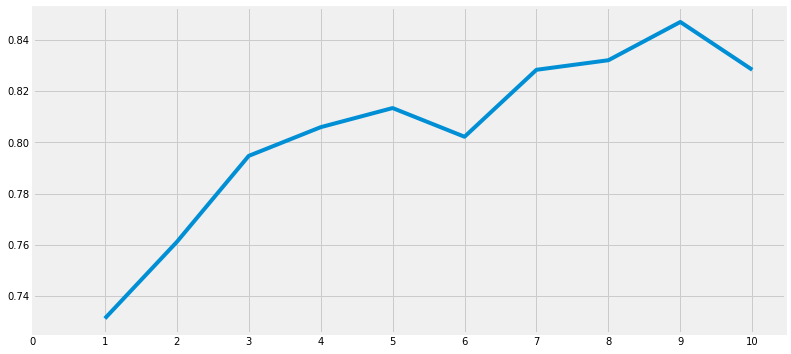

Accuracies for different values of n are: [0.73134328 0.76119403 0.79477612 0.80597015 0.81343284 0.80223881
 0.82835821 0.83208955 0.84701493 0.82835821] with the max value as 0.8470149253731343


In [125]:
a_index= list(range(1,11))
a=pd.Series()
x=[0,1,2,3,4,5,6,7,8,9,10]
for i in list(range(1,11)):
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(train_X, train_Y)
    prediction = model.predict(test_X)
    a = a.append(pd.Series(metrics.accuracy_score(prediction, test_Y)))
    
plt.plot(a_index, a)
plt.xticks(x)
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()
print("Accuracies for different values of n are:", a.values, "with the max value as", a.values.max())

### 가우시안 나이브베이즈


In [126]:
model = GaussianNB()
model.fit(train_X, train_Y)
prediction6 = model.predict(test_X)
print("The accuracy of the NaiveBayes is", metrics.accuracy_score(prediction6, test_Y))

The accuracy of the NaiveBayes is 0.8134328358208955


### 랜덤포레스트

In [127]:
model = RandomForestClassifier(n_estimators=100)
model.fit(train_X, train_Y)
prediction7 = model.predict(test_X)
print("The accuracy of the Random Forests is", metrics.accuracy_score(prediction7, test_Y))

The accuracy of the Random Forests is 0.8171641791044776


- 모델의 정확도가 분류기의 견고성을 결정하는 유일한 요소는 아닙니다. 분류기가 훈련데이터에 대해 훈련되고 테스트 데이터에 대해 테스트되었으며 90%의 정확도를 기록했다고 가정해보겠습니다
- 이제 이것은 분류기의 정확도가 매우 좋은 것 같지만, 오는 모든 새로운 테스트 세트에 대해 90%임을 확인할 수 있습니다. 대답은 아니오입니다.
- 분류기가 자체 학습에 사용할 모든 인스턴스를 결정할 수 없기 때문입니다.
- 훈련 및 테스트 데이터가 변경되면 정확도도 변경됩니다. 증가하거나 감소할 수 있습니다. 이것을 모델 분산이라고 합니다.
- 이를 극복하고 일반화된 모델을 얻기 위해 cross validation을 사용합니다

### 교차검증
- 데이터가 불균형합니다. 즉, class1인스턴스의 수는 많지만 다른 클래스 인스턴스의 수는 적을 수 있습ㄴ디ㅏ. 따라서 데이터 세트의 모든 인스턴스에ㅐ 대해 알고리즘을 훈련하고 테스트해야 합니다. 그런 다음 데이터 세트에 대해 언급된 모든 정확도의 평균을 취할 수 있습니다.
- 1)K-Fold 교차 검증은 먼저 데이터 세트를 k-서브셋으로 나눕니다
- 2) 데이터세트를 (k=5) 부분으로 나눕니다. 테스트를 위해 1개 부분을 예약하고 4개 부분에 대해 알고리즘을 훈련합니다
- 3)각 반복에서 테스트 부분을 변경하고 다른 부분에 대해 알고리즘을 학습하여 프로세스를 계속합니다. 그런 다음 정확도와 오류를 평균하여 알고리즘의 평균 정확도를 얻습니다. 이것을 K-Fold 교차 검증이라고 합니다.
- 4) 알고리즘은 일부 훈련 데이터에 대한 데이터 세트에 대해 과소적합될 수 있고, 때로는 다른 훈련 세트에 대한 데이터에 과대적합될 수도 있습니다. 따라서 교차 검증을 통해 일반화된 모델을 얻을 수 있습니다.

In [128]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
kfold = KFold(n_splits=10, random_state=22, shuffle = True)
xyz=[]
accuracy=[]
std=[]
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree','Naive Bayes','Random Forest']
models = [svm.SVC(kernel="linear"), svm.SVC(kernel="rbf"), LogisticRegression(), KNeighborsClassifier(n_neighbors=9),DecisionTreeClassifier(), GaussianNB(), RandomForestClassifier(n_estimators=100)]
for i in models:
    model = i
    cv_result = cross_val_score(model, X,Y,cv=kfold,scoring="accuracy")
    cv_result = cv_result
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
new_models_dataframe2 = pd.DataFrame({"CV Mean":xyz, "Std":std}, index=classifiers)
new_models_dataframe2

,CV Mean,Std
Linear Svm,0.784607,0.057841
Radial Svm,0.828377,0.057096
Logistic Regression,0.799176,0.040154
KNN,0.808140,0.035630
Decision Tree,0.808102,0.042658
Naive Bayes,0.795843,0.054861
Random Forest,0.813745,0.040883


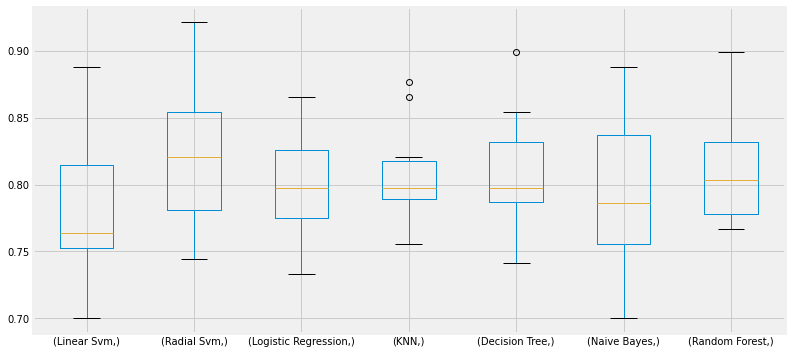

In [129]:
plt.subplots(figsize=(12,6))
box = pd.DataFrame(accuracy,index=[classifiers])
box.T.boxplot()

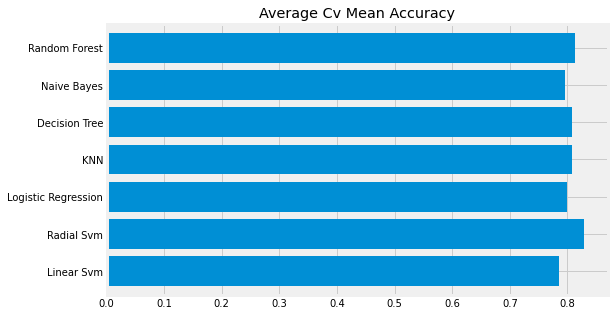

In [130]:
new_models_dataframe2["CV Mean"].plot.barh(width=0.8)
plt.title("Average Cv Mean Accuracy")
fig=plt.gcf()
fig.set_size_inches(8,5)
plt.show()

- 분류 정확도는 불균형으로 인해 때때로 오해의 소지가 있습니다. 모델이 어디에서 잘못되었는지 또는 모델이 어떤 클래스를 잘못 예측했는지 보여주는 혼동행렬의 도움으로 요약된 결과를 얻을 수 있습니다.


### 혼동행렬
- 분류자가 만든 올바른 분류와 잘못된 분류의 수를 제공합니다

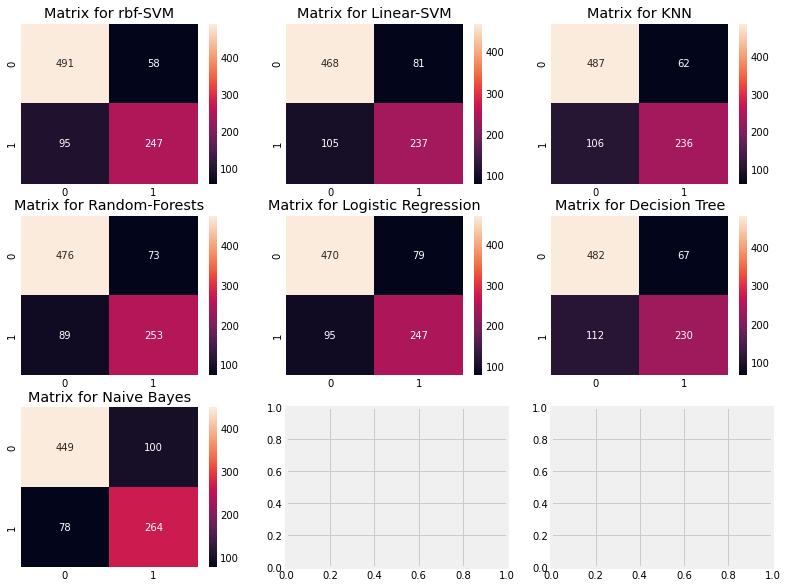

In [131]:
f,ax=plt.subplots(3,3,figsize=(12,10))
y_pred = cross_val_predict(svm.SVC(kernel='rbf'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,0],annot=True,fmt='2.0f')
ax[0,0].set_title('Matrix for rbf-SVM')
y_pred = cross_val_predict(svm.SVC(kernel='linear'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,1],annot=True,fmt='2.0f')
ax[0,1].set_title('Matrix for Linear-SVM')
y_pred = cross_val_predict(KNeighborsClassifier(n_neighbors=9),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,2],annot=True,fmt='2.0f')
ax[0,2].set_title('Matrix for KNN')
y_pred = cross_val_predict(RandomForestClassifier(n_estimators=100),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,0],annot=True,fmt='2.0f')
ax[1,0].set_title('Matrix for Random-Forests')
y_pred = cross_val_predict(LogisticRegression(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,1],annot=True,fmt='2.0f')
ax[1,1].set_title('Matrix for Logistic Regression')
y_pred = cross_val_predict(DecisionTreeClassifier(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,2],annot=True,fmt='2.0f')
ax[1,2].set_title('Matrix for Decision Tree')
y_pred = cross_val_predict(GaussianNB(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[2,0],annot=True,fmt='2.0f')
ax[2,0].set_title('Matrix for Naive Bayes')
plt.subplots_adjust(hspace=0.2,wspace=0.2)
plt.show()

### 혼동행렬 해석
- 왼쪽 대각선은 각 클래스에 대해 수행된 올바른 예측의 수를 나타내고, 오른쪽 대각선은 잘못된 예측의 수를 나타냅니다. rbf_SVM의 첫 번째 플롯을 살펴보겠습니다.
- 정확한 예측은 491(사망) + 247(생존)이며 평균 cv정확도는 (491+247)/891 = 82.8% 입니다.
- 오류-> 58명의 사망자를 생존자로, 95명이 사망한 것으로 잘못 분류했습니다. 따라서 죽은 사람을 생존자로 예측함으로써 더 많은 실수를 저질렀습니다.
- 모든 행렬을 보면 rbf-SVM이 사망한 승객을 정확하게 예측할 확률이 더 높지만, 나이브베이즈가 생존한 승객을 정확하게 예측할 확률이 더 높다고 말할 수 있습니다.


### 하이퍼 파라미터 조정
- 기계학습모델은 블랙박스와 같습니다.
- 이 블랙박스에 대한 몇 가지 기본 매개변수 값이 있으며 더 나은 모델을 얻기 위해 조정하거나 변경할 수 있습니다. SVM 모델의  C및 감마와 마찬가지로 다른 분류기에 대한 유사하게 다른 매개변수를 하이퍼 파라미터라고하며, 알고리즘의 학습률을 변경하고 더 나은 모델을 얻기 위해 조정할 수 있습니다.
이것을 하이퍼 파라미터 튜닝이라고 합니다.
- 우리는 SVM과 RandomForests와 같은 2개의 최고의 분류기에 대한 하이퍼 파라미터를 조정할 것입니다


### SVM

In [132]:
from sklearn.model_selection import GridSearchCV
#C=[0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]
#gamma=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
#시간 소요로 인해 앞의 일부만 사용
C=[0.05,0.1,0.2,0.3,0.4,0.5]
gamma=[0.1,0.2,0.3]
kernel=["rbf", "linear"]
hyper = {"kernel":kernel, "C":C, "gamma":gamma}
gd = GridSearchCV(estimator=svm.SVC(), param_grid=hyper, verbose=True)
gd.fit(X,Y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
0.8282593685267716
SVC(C=0.4, gamma=0.3)


### 랜덤포레스트

In [133]:
n_estimators=range(100,500,100)
hyper = {"n_estimators":n_estimators}
gd = GridSearchCV(estimator=RandomForestClassifier(random_state=0), param_grid=hyper, verbose=True)
gd.fit(X,Y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
0.819327098110602
RandomForestClassifier(n_estimators=300, random_state=0)


rbf-svm의 최고점수는 c=0.05 및 감마 0.1일때 82.82%입니다. RandomForest의 경우 점수는 n_estimators=300일 때 약 81.93%입니다

### 앙상블
- 앙상블은 모델의 정확도나 성능을 높이는 좋은 방법입니다. 간단히 말해서 다양한 단순 모델을 조합하여 하나의 강력한 모델을 만드는 것입니다.
- 전화기를 구입하고 다양한 매개변수를 기반으로 많은 사람들에게 이에 대해 물어보고 싶다고 가정해보겠습니다. 
- 따라서 우리는 모든 다른 매개변수를 분석한 후 단일 제품에 대해 강력한 판단을 내릴 수 있습니다. 모델의 안정성을 향상시키는 앙상블입니다. 앙상블은 다음과 같은 방법으로 수행할 수 있습니다.
- voting regressor, bagging, boosting


### voting classifier
- 다양한 단순 기계 학습 모델의 예측을 결합하는 가장 간단한 방법입니다.
- 모든 하위 모델의 예측을 기반으로 평균 예측 결과를 제공합니다. 하위 모델 또는 기본 모델은 모두 다른 유형입니다.

In [134]:
from sklearn.ensemble import VotingClassifier
ensemble_lin_rbf=VotingClassifier(estimators=[('KNN',KNeighborsClassifier(n_neighbors=10)),
                                              ('RBF',svm.SVC(probability=True,kernel='rbf',C=0.5,gamma=0.1)),
                                              ('RFor',RandomForestClassifier(n_estimators=500,random_state=0)),
                                              ('LR',LogisticRegression(C=0.05)),
                                              ('DT',DecisionTreeClassifier(random_state=0)),
                                              ('NB',GaussianNB()),
                                              ('svm',svm.SVC(kernel='linear',probability=True))
                                             ], 
                       voting='soft').fit(train_X,train_Y)
print('The accuracy for ensembled model is:',ensemble_lin_rbf.score(test_X,test_Y))
cross=cross_val_score(ensemble_lin_rbf,X,Y, cv = 10,scoring = "accuracy")
print('The cross validated score is',cross.mean())

The accuracy for ensembled model is: 0.8208955223880597
The cross validated score is 0.8249188514357053


### 배깅
- 배깅은 일반적인 앙상블 방법입니다. 데이터세트의 작은 파티션에 유사한 분류기를 적용한 다음 모든 예측의 평균을 취하여 작동합니다. 평균화로 인해 분산이 감소합니다. 투표 분류기와 달리 배깅은 유사한 분류기를 사용합니다.

### bagged KNN
- 배깅은 분산이 높은 모델에서 가장 잘 작동합니다. 이에 대한 예로는 의사결정 트리 또는 랜덤 포레스트가 있습니다. n_neighbors의 작은 값으로 KNN을 n_neighbors의 작은 값으로 사용할 수 있습니다.

In [135]:
from sklearn.ensemble import BaggingClassifier
model=BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=3),random_state=0,n_estimators=700)
model.fit(train_X,train_Y)
prediction=model.predict(test_X)
print('The accuracy for bagged KNN is:',metrics.accuracy_score(prediction,test_Y))
result=cross_val_score(model,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for bagged KNN is:',result.mean())

The accuracy for bagged KNN is: 0.832089552238806
The cross validated score for bagged KNN is: 0.8104244694132333


### bagged 결정나무

In [136]:
model=BaggingClassifier(base_estimator=DecisionTreeClassifier(),random_state=0,n_estimators=100)
model.fit(train_X,train_Y)
prediction=model.predict(test_X)
print('The accuracy for bagged Decision Tree is:',metrics.accuracy_score(prediction,test_Y))
result=cross_val_score(model,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for bagged Decision Tree is:',result.mean())

The accuracy for bagged Decision Tree is: 0.8208955223880597
The cross validated score for bagged Decision Tree is: 0.8171410736579275


### 부스팅
- 부스팅은 분류기의 순차적 학습을 사용하는 앙상블 기술입니다. 약한 모델을 단계적으로 개선하는 것입니다. 부스팅은 다음과 같이 작동합니다.
- 모델은 먼저 전체 데이터 세트에서 학습됩니다. 이제 모델은 일부 인스턴스를 맞고 일부 인스턴스를 틀리게 됩니다.
- 이제 다음 반복에서 학습자는 잘못 예측된 인스턴스에 더 집중하거나 더 많은 가중치를 부여합니다.
- 따라서 잘못된 인스턴스를 올바르게 예측하려고 시도합니다.
- 이제 이 반복적인 프로세스가 계속되고 정확도의 한계에 도달할 때 까지 새로운 분류기가 모델에 추가됩니다


### adaboost(에이다 부스팅)
- 약한 학습자 또는 추정기는 의사결정스티입니다. 그러나 기본 base_estimator를 우리가 선택한 알고리즘으로 변경할 수 있습니다.

In [137]:
from sklearn.ensemble import AdaBoostClassifier
ada=AdaBoostClassifier(n_estimators=200,random_state=0,learning_rate=0.1)
result=cross_val_score(ada,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for AdaBoost is:',result.mean())

The cross validated score for AdaBoost is: 0.8249188514357055


### stochastic 그라디언트 부스팅
- 여기에도 약한 학습자는 의사결정나무입니다

In [138]:
from sklearn.ensemble import GradientBoostingClassifier
grad=GradientBoostingClassifier(n_estimators=500,random_state=0,learning_rate=0.1)
result=cross_val_score(grad,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for Gradient Boosting is:',result.mean())

The cross validated score for Gradient Boosting is: 0.8115230961298376


### XGBoost

In [139]:
import xgboost as xg
xgboost=xg.XGBClassifier(n_estimators=900,learning_rate=0.1)
result=cross_val_score(xgboost,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for XGBoost is:',result.mean())

The cross validated score for XGBoost is: 0.8115480649188515


- adaboost에서 가장 높은 정확도를 얻었습니다. 하이퍼파라미터 튜닝으로 성능을 높여보겠습니다.

### adaboost를 위한 하이퍼 파라미터 튜닝

In [140]:
n_estimators=list(range(100,300,100))
learn_rate=[0.05,0.1,0.2]
hyper={'n_estimators':n_estimators,'learning_rate':learn_rate}
gd=GridSearchCV(estimator=AdaBoostClassifier(),param_grid=hyper,verbose=True)
gd.fit(X,Y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
0.8293892411022534
AdaBoostClassifier(learning_rate=0.1, n_estimators=100)


- adaboost로 얻을 수 있는 최대 정확도는 n_estimators=100 및 learning_rate=0.1일 때 82.93%입니다

### 최고의 모델을 위한 혼동행렬

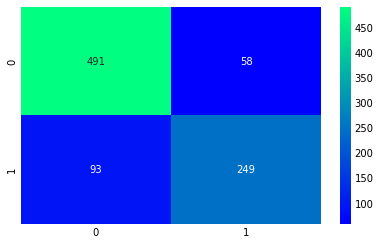

In [141]:
ada=AdaBoostClassifier(n_estimators=200,random_state=0,learning_rate=0.05)
result=cross_val_predict(ada,X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,result),cmap='winter',annot=True,fmt='2.0f')
plt.show()

## Feature Importance

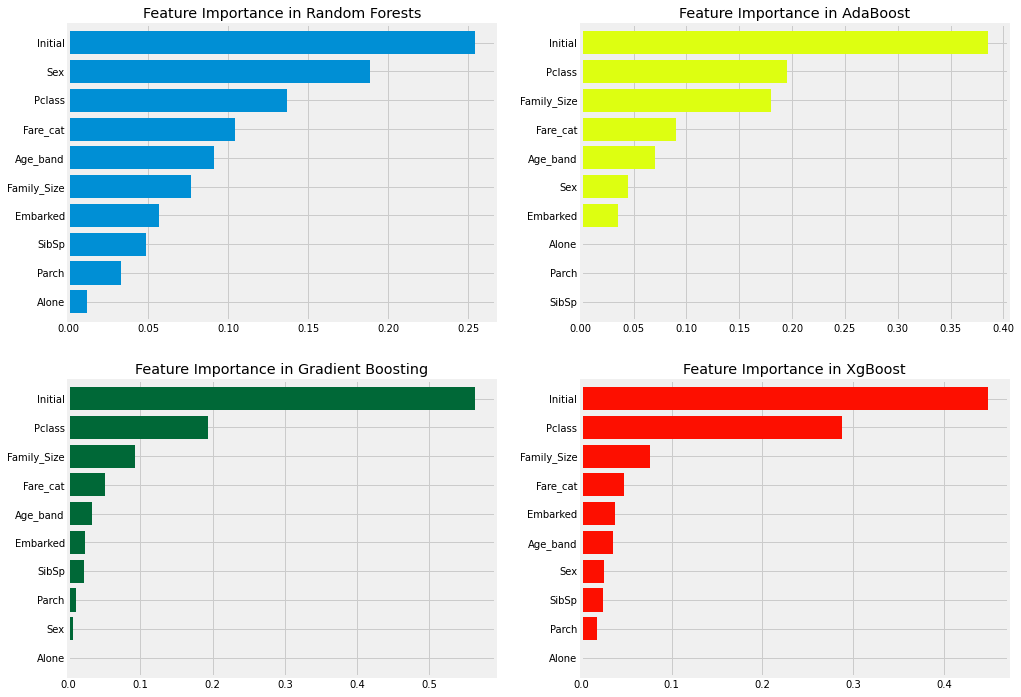

In [142]:
f,ax=plt.subplots(2,2,figsize=(15,12))
model=RandomForestClassifier(n_estimators=500,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,0])
ax[0,0].set_title('Feature Importance in Random Forests')
model=AdaBoostClassifier(n_estimators=200,learning_rate=0.05,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,1],color='#ddff11')
ax[0,1].set_title('Feature Importance in AdaBoost')
model=GradientBoostingClassifier(n_estimators=500,learning_rate=0.1,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,0],cmap='RdYlGn_r')
ax[1,0].set_title('Feature Importance in Gradient Boosting')
model=xg.XGBClassifier(n_estimators=900,learning_rate=0.1)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,1],color='#FD0F00')
ax[1,1].set_title('Feature Importance in XgBoost')
plt.show()

- randomforest, adaboost 등과 같은 다양한 분류기의 중요한 기능을 볼 수 있습니다.

### 관찰 : 
- 일반적인 중요한 기능 중 일부는 initial, fare_cat, pclass, family_size 입니다
- 성별은 중요하지 않은 것 같습니다. pclass와 성별이 결합된 것이 매우 좋은 차별화 요소를 제공했지만, 성별 자체는 랜덤포레스트에서만 중요한 것 같습니다
- 그러나 우리는 많은 분류기에서 맨 위에 있는 initial 기능을 볼 수 있습니다. 우리는 성별과 이니셜 사이의 양의 상관관계를 보았으므로 둘 다 성별을 나타냅니다.
- 유사하게 pclass 및 fare_cat은 alone, parch 및 SibSp와 함께 승객 및 family_size의 상태를 나타냅니다.